In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
from statsmodels.stats.anova import AnovaRM
from sklearn.metrics import precision_recall_fscore_support

In [28]:
root_path = os.path.abspath(os.path.join('..', '..'))
from dataloaders.dataloader_REALDISP_har import REALDISPUtils
train_device_1 = 'RLA-ideal'  # Also the test device
train_device_2 = 'RLA-self'
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
           26, 27, 28, 29, 30, 31, 32, 33]
train_keys = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [29]:
# Method for creating a multi bar graph with x axis and y axis values in the for of a list
'''
x: list of x axis labels
y: list of y axis values
x_label: x axis label
y_label: y axis label
title: title of the graph
width: width of the graph
height: height of the graph
bar_width: width of each bar
'''


def generate_multi_bar_graph(data_frame, x_label, y_label, title, width, height, bar_width, std=False):
    # set the width of the bars
    bar_width = bar_width
    sns.barplot(data_frame, x=x_label, y=y_label, palette='dark', errorbar='sd' if std else None)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(0, 1)
    plt.legend(loc='upper right')
    plt.xticks(rotation=45)
    plt.gcf().set_size_inches(width, height)
    plt.show()


def get_f1_df(model_device, test_device):
    data = {'Device': [], 'F1 Score': [], 'model_type': [], 'cv': []}
    df = pd.DataFrame(data)

    for i in train_keys:
        new_row = {'Device': test_device,
                   'F1 Score': get_result_for_model(root_path, model_device, test_device, 'attend', i)[3],
                   'model_type': 'attend',
                   'cv': i}
        df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
        new_row = {'Device': test_device,
                   'F1 Score': get_result_for_model(root_path, model_device, test_device, 'deepconv', i)[3],
                   'model_type': 'deepconv',
                   'cv': i}
        df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
        new_row = {'Device': test_device,
                   'F1 Score': get_result_for_model(root_path, model_device, test_device, 'tinyhar', i)[3],
                   'model_type': 'tinyhar',
                   'cv': i}
        df = pd.concat([df, pd.DataFrame(new_row, index=[0])], ignore_index=True)
    return df


def generate_graph_with_std(root_path, model_device, test_devices):
    df = get_f1_df(model_device, test_devices)

    # generate the graph
    g = sns.catplot(x='Device', y='F1 Score', hue='model_type', data=df, kind='bar', palette='dark', errorbar='sd',
                    alpha=.6, height=6, aspect=2).set(title='F1 Score for Model trained with ' + model_device)
    g.despine(left=True)
    g.set_ylabels('F1 Score')
    g.set_xlabels('Device')
    g.set_xticklabels(rotation=45)

    # save the graph in folder mean_graphs in the logs, create folder if not exists
    if not os.path.exists(os.path.join(root_path, 'data', 'Run_logs', model_device, 'logs', 'mean_graphs')):
        os.makedirs(os.path.join(root_path, 'data', 'Run_logs', model_device, 'logs', 'mean_graphs'))
    # plt.savefig(os.path.join(root_path, 'data', 'Run_logs', model_device, 'logs', 'mean_graphs',
    #                          'F1 Score for Model trained with ' + model_device + '.png'))




In [30]:
# Method used for getting the right path for a model based on the device name and the cv number
'''
root_path: the root path of the project
device: the device name
cv: the cross validation number

Acceptable model types: attend, deepconv, tinyhar
'''


def get_model_path(root_path, variant, model_type, cv):
    path = root_path
    parent_path = os.path.join(path, 'data', 'Run_logs', variant, 'logs')
    # parent paths has three folders for attend, deepCONV, TinyHAR. Get a list of all folders in the parent path
    folders = os.listdir(parent_path)
    for folder in folders:
        if model_type in folder:
            path = os.path.join(parent_path, folder)
            break
    # path now has the path to the model type folder
    path = os.path.join(path, 'cv_' + str(cv))
    return path


def get_result_for_model(root_path, model_variant, test_variant, model_type, cv):
    path = get_model_path(root_path, model_variant, model_type, cv)
    filename = 'prediction_result_' + model_variant + '_' + test_variant + '.csv'
    path = os.path.join(path, filename)
    # open the csv file prediction_result_ and read the data
    csv_file = path
    # open with pandas
    df = pd.read_csv(csv_file)
    # if the file is empty, continue
    if df.empty:
        return None

    # get the prediction result
    preds = df['preds'].values
    # get the ground truth
    trues = df['trues'].values

    num_classes = 34
    classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25,
               26, 27, 28, 29, 30, 31, 32, 33]

    # Calculate precision, recall, and f1 for each class. Use zero devision as 0
    precision, recall, f1_weighted, _ = precision_recall_fscore_support(trues, preds, labels=classes,
                                                                        average='weighted', zero_division=0)
    # Calculate macro
    _, _, f1_macro, _ = precision_recall_fscore_support(trues, preds, labels=classes, average='macro', zero_division=0)

    accuracy = np.sum(preds == trues) / len(preds)

    return accuracy, precision, recall, f1_macro, f1_weighted  #, preds, trues


def create_confusion_matrix(root_path, model_variant, test_variant, model_type, cv):
    path = get_model_path(root_path, model_variant, model_type, cv)
    filename = 'prediction_result_' + model_variant + '_' + test_variant + '.csv'
    path = os.path.join(path, filename)
    # open the csv file prediction_result_ and read the data
    csv_file = path
    # open with pandas
    df = pd.read_csv(csv_file)
    # if the file is empty, continue
    if df.empty:
        return None

    # get the prediction result
    preds = df['preds'].values
    # get the ground truth
    trues = df['trues'].values

    # create confusion matrix
    cm = confusion_matrix(trues, preds, labels=classes)
    # plot the confusion matrix
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # print the f1 score from the confusion matrix
    precision, recall, f1_weighted, _ = precision_recall_fscore_support(trues, preds, labels=classes,
                                                                        average='weighted', zero_division=0)
    print('F1 Score:', f1_weighted)

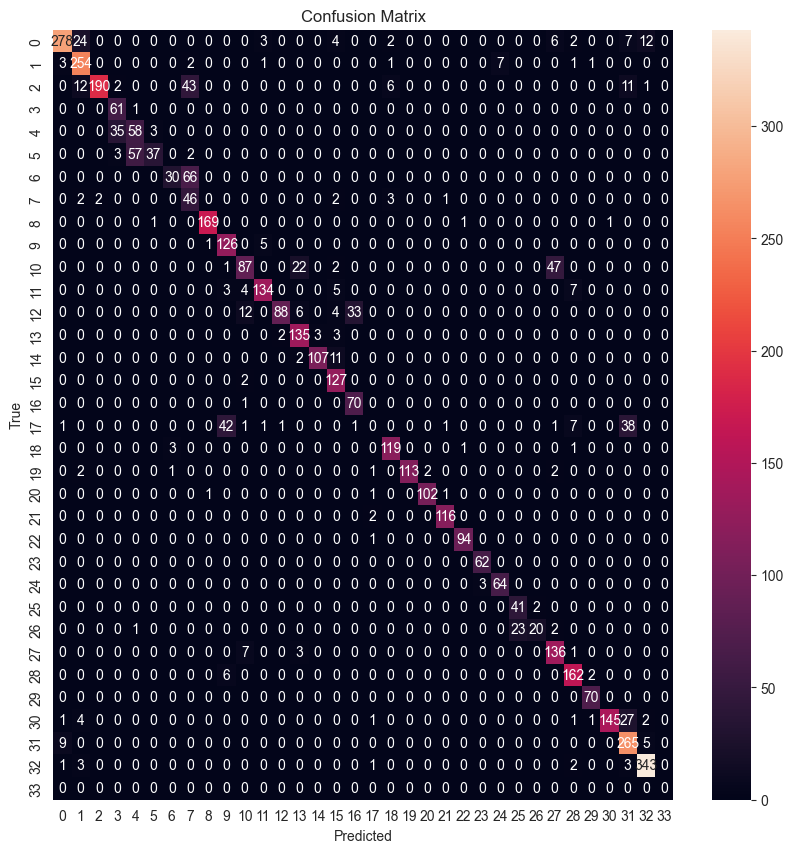

F1 Score: 0.831818664629819


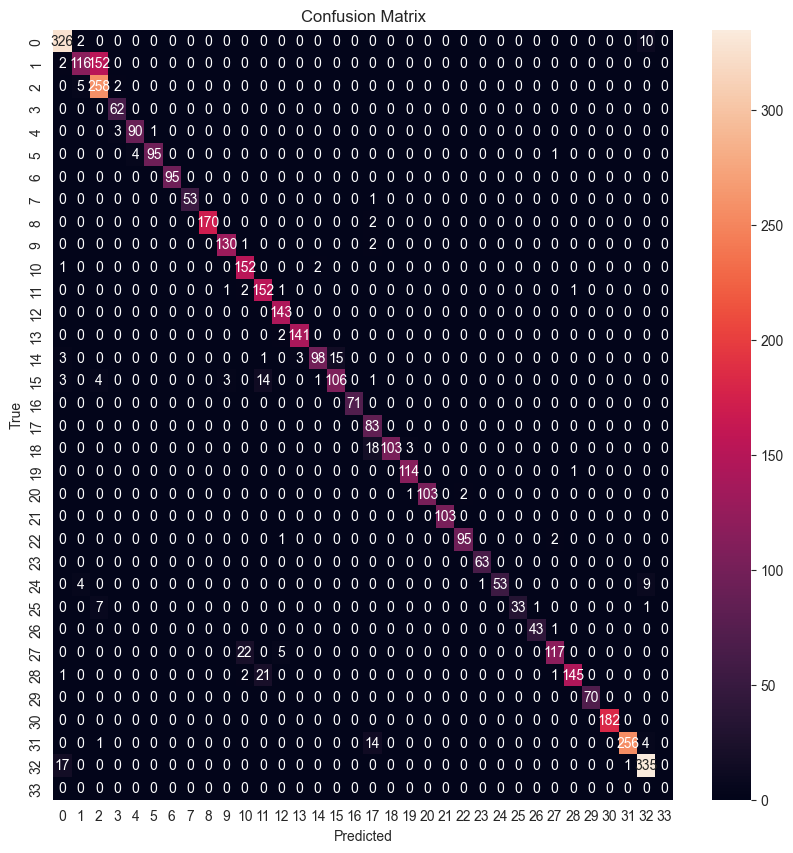

F1 Score: 0.9126420692158086


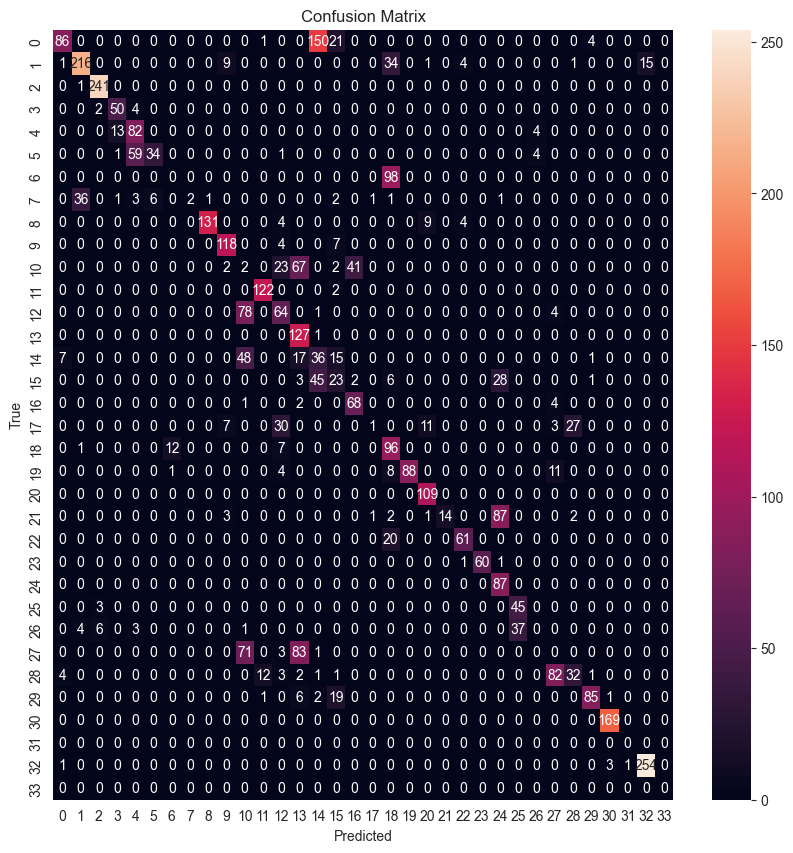

F1 Score: 0.6025747567469077


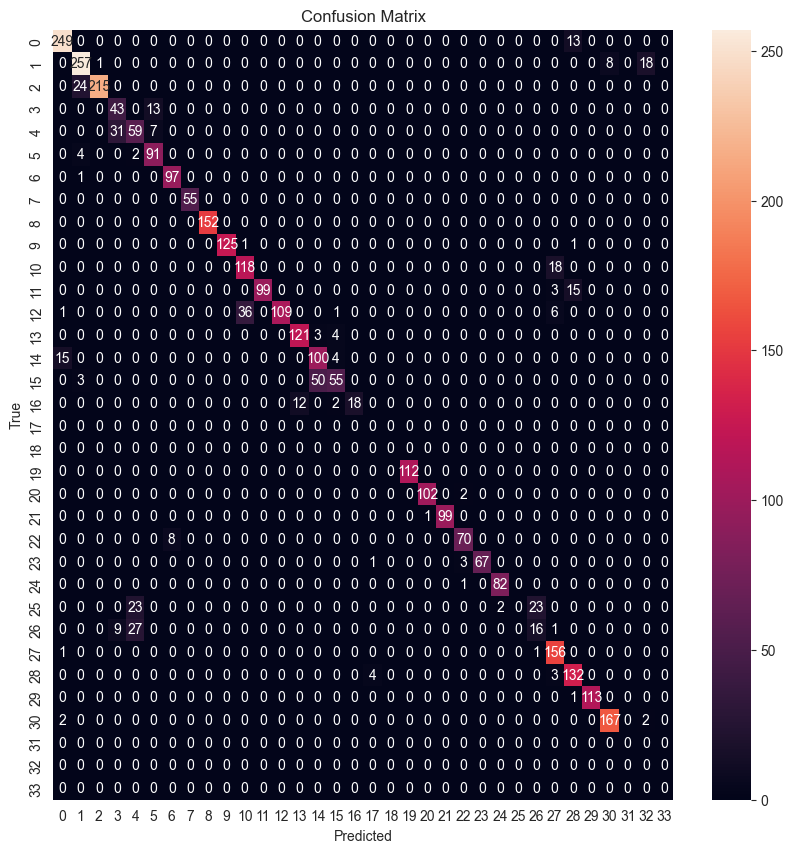

F1 Score: 0.8786332332047698


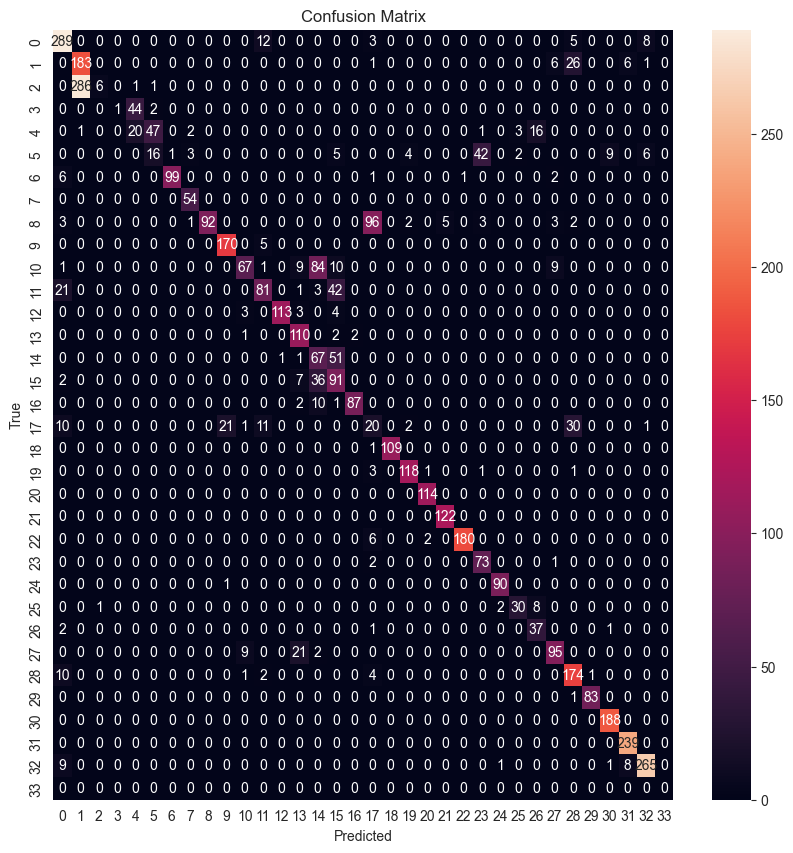

F1 Score: 0.7289636949577947


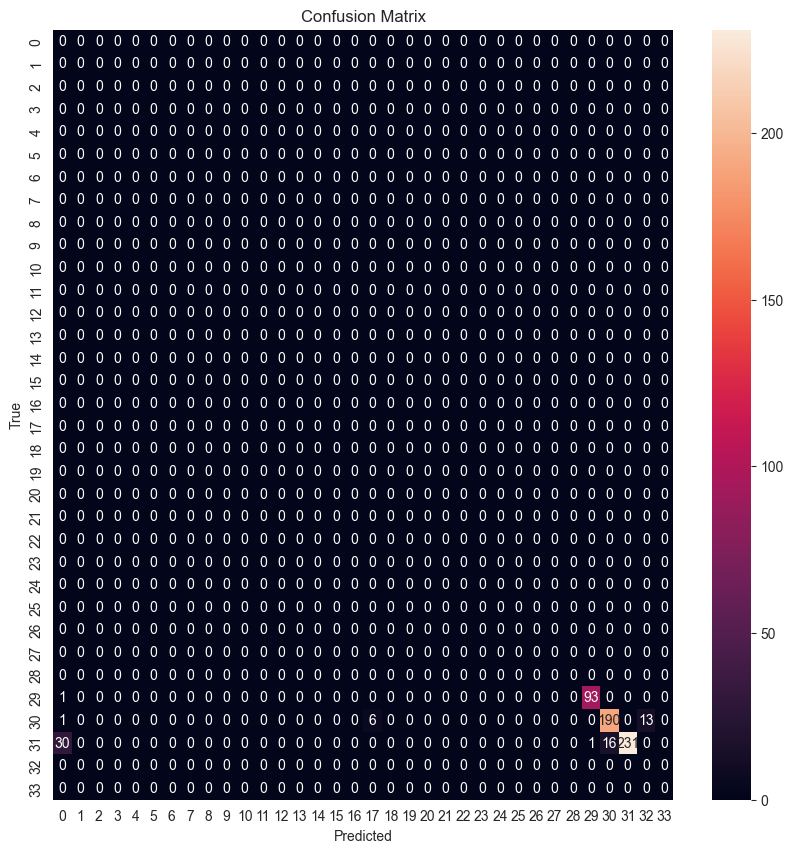

F1 Score: 0.9229501409209955


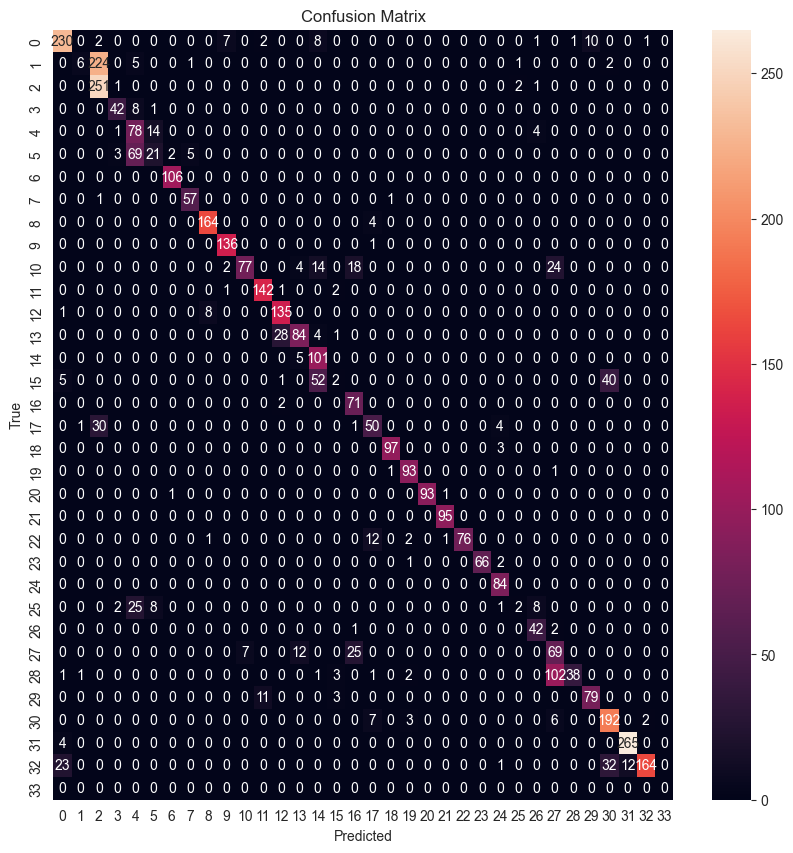

F1 Score: 0.7379572560570149


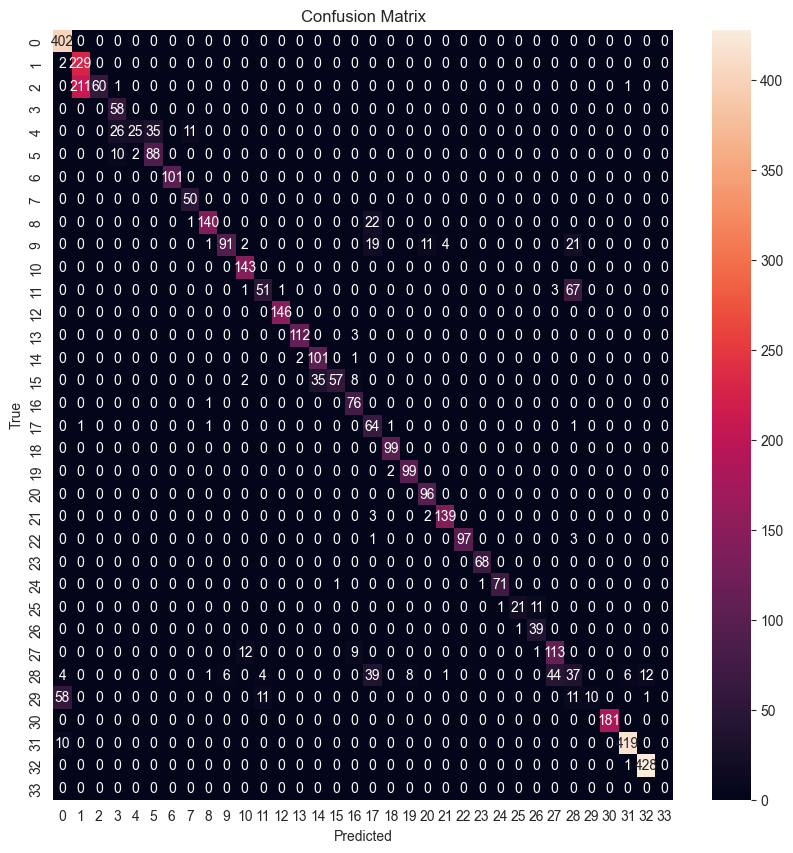

F1 Score: 0.8159345569944932


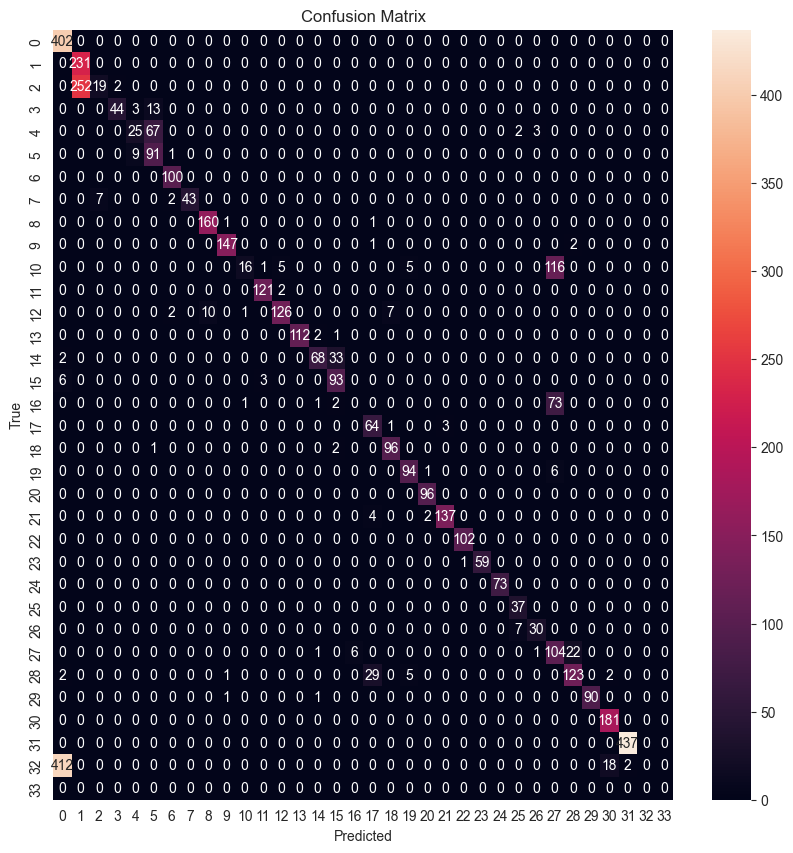

F1 Score: 0.6960540931755215


In [31]:
create_confusion_matrix(root_path, 'RLA-ideal', 'RLA-ideal', 'attend', 0)
create_confusion_matrix(root_path, 'RLA-ideal', 'RLA-ideal', 'attend', 1)
create_confusion_matrix(root_path, 'RLA-ideal', 'RLA-ideal', 'attend', 2)
create_confusion_matrix(root_path, 'RLA-ideal', 'RLA-ideal', 'attend', 3)
create_confusion_matrix(root_path, 'RLA-ideal', 'RLA-ideal', 'attend', 4)
create_confusion_matrix(root_path, 'RLA-ideal', 'RLA-ideal', 'attend', 5)
create_confusion_matrix(root_path, 'RLA-ideal', 'RLA-ideal', 'attend', 6)
create_confusion_matrix(root_path, 'RLA-ideal', 'RLA-ideal', 'attend', 7)
create_confusion_matrix(root_path, 'RLA-ideal', 'RLA-ideal', 'attend', 8)

## 1 v 1 Graphs and Info

## MMD Graphs

D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
D:\Concordia\PERCOM_Variability_Model_Research\venv\lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


             activity       mmd  std_div_mmd        f1
activity     1.000000 -0.166302     0.396005 -0.879304
mmd         -0.166302  1.000000     0.610396 -0.074492
std_div_mmd  0.396005  0.610396     1.000000 -0.425071
f1          -0.879304 -0.074492    -0.425071  1.000000
             activity       mmd  std_div_mmd        f1
activity     1.000000  0.672750     0.692010 -0.739606
mmd          0.672750  1.000000     0.336600 -0.854876
std_div_mmd  0.692010  0.336600     1.000000 -0.352897
f1          -0.739606 -0.854876    -0.352897  1.000000


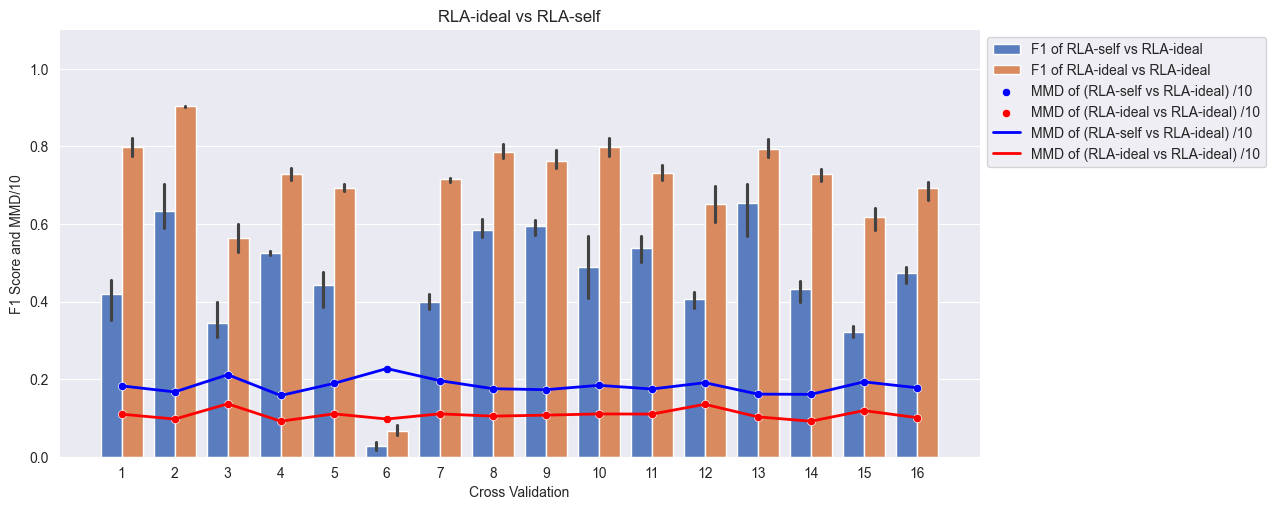

In [32]:
sensor_test = "RLA-ideal"
sensor_train = "RLA-self"
result_list = []
for i in range(16):
    did_run = True
    for model in ['attend', 'deepconv', 'tinyhar']:
        result1 = get_result_for_model(root_path, sensor_train, sensor_test, model, i)
        result2 = get_result_for_model(root_path, sensor_test, sensor_test, model, i)

        if result1 == None or result2 == None:
            break

        dict_results = {'f1': result1[3],
                        'cv': i + 1,
                        'device_config': 'F1 of ' + sensor_train + ' vs ' + sensor_test, 'model_type': model}
        result_list.append(dict_results)
        dict_results = {'f1': result2[3],
                        'cv': i + 1,
                        'device_config': 'F1 of ' + sensor_test + ' vs ' + sensor_test, 'model_type': model}
        result_list.append(dict_results)

df = pd.DataFrame(result_list)

# plot the f1 score for all participants as bar graph using sns catplot bar with colors red and blue
sns.catplot(x='cv', y='f1', hue='device_config', data=df, kind='bar', aspect=2, height=5, palette='muted',
            legend_out=False)
plt.title(sensor_test + ' vs ' + sensor_train)
plt.xlabel('Cross Validation')
plt.ylabel('F1 Score and MMD/10')
# plot max y value is 1.1
plt.ylim(0, 1.1)

file_activity = 'using_3d_per_activity'

# read the mmd values from the csv
path = os.path.join(root_path, 'data', 'mmd', file_activity,
                    'mmd_results_' + sensor_test + '_' + sensor_test + '.csv')
mmd_1_1 = pd.read_csv(path)
# print(mmd_1_1)
path = os.path.join(root_path, 'data', 'mmd', file_activity,
                    'mmd_results_' + sensor_train + '_' + sensor_test + '.csv')
mmd_2_1 = pd.read_csv(path)

''' Get the mean for all activities for each cv '''
mmd_1_1 = mmd_1_1.groupby('CV').mean()
mmd_2_1 = mmd_2_1.groupby('CV').mean()

# reset the index
mmd_1_1 = mmd_1_1.reset_index(drop=True)
mmd_2_1 = mmd_2_1.reset_index(drop=True)

# set the CV values to be 1 to len
len_df = len(mmd_1_1)
mmd_1_1['CV'] = range(1, len_df + 1)
mmd_2_1['CV'] = range(1, len_df + 1)

# divide the df into two based on device_config
f1_1_1 = df[(df['device_config'] == 'F1 of ' + sensor_test + ' vs ' + sensor_test)]
f1_2_1 = df[(df['device_config'] == 'F1 of ' + sensor_train + ' vs ' + sensor_test)]
# drop model_type
f1_1_1 = f1_1_1.drop(columns='model_type')
f1_2_1 = f1_2_1.drop(columns='model_type')
# drop device_config
f1_1_1 = f1_1_1.drop(columns='device_config')
f1_2_1 = f1_2_1.drop(columns='device_config')

# get the mean of all models for each cv
f1_1_1 = f1_1_1.groupby('cv').mean()
f1_2_1 = f1_2_1.groupby('cv').mean()

# make the cv column the index
mmd_1_1 = mmd_1_1.set_index('CV')
mmd_2_1 = mmd_2_1.set_index('CV')

# finding the corelation between mmd and f1 score for 1_1
mmd_1_1['f1'] = f1_1_1['f1']
mmd_2_1['f1'] = f1_2_1['f1']


print(mmd_1_1.corr())
print(mmd_2_1.corr())

# divide MMD value by 10
mmd_1_1['mmd'] = mmd_1_1['mmd'] / 10
mmd_2_1['mmd'] = mmd_2_1['mmd'] / 10

# reset the index to be 0 to len
mmd_1_1 = mmd_1_1.reset_index()
mmd_2_1 = mmd_2_1.reset_index()
# plot the mmd values not only as line but also as points on the graph
sns.scatterplot(data=mmd_2_1['mmd'], color='blue', label='MMD of (' + sensor_train + ' vs ' + sensor_test + ') /10')
ax = sns.scatterplot(data=mmd_1_1['mmd'], color='red',
                     label='MMD of (' + sensor_test + ' vs ' + sensor_test + ') /10')
# plot the mmd values on top of the f1 score. with x as cv, with thickness 2
sns.lineplot(data=mmd_2_1['mmd'], color='blue', label='MMD of (' + sensor_train + ' vs ' + sensor_test + ') /10',
             linewidth=2)
ax = sns.lineplot(data=mmd_1_1['mmd'], color='red', label='MMD of (' + sensor_test + ' vs ' + sensor_test + ') /10',
                  linewidth=2)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.show()


In [33]:
data_util = REALDISPUtils()

In [34]:
data = data_util.load_all_the_data_realdisp(os.path.join(root_path, "data", "realdisp"), 'RLA-ideal', range(1,18))

 ----------------------- load all the data -------------------


In [35]:
test = data

In [36]:
sensor_data = test[0]

In [37]:
activity = test[1]

In [38]:
# concat the sensor data and activty in a new dataframe
sensor_data = pd.concat([sensor_data, activity], axis=1)

In [39]:
sensor_data

,sub_id,RLA_ACC_X,RLA_ACC_Y,RLA_ACC_Z,sub,activity_id
0,1,-0.072440,7.5862,6.9133,1,1
1,1,0.047983,6.9829,6.6456,1,1
2,1,0.098941,7.1174,6.7306,1,1
3,1,0.001608,6.7863,6.5130,1,1
4,1,0.044153,6.1542,6.3841,1,1
...,...,...,...,...,...,...
711817,17,1.245700,6.7171,8.5888,17,31
711818,17,1.112800,6.2396,8.8672,17,31
711819,17,-0.154280,6.2409,9.5712,17,31
711820,17,-1.407800,7.2949,9.6762,17,31


In [40]:
# count the number of activities per cv
activity_count = sensor_data.groupby('sub').count()

In [41]:
activity_count

,sub_id,RLA_ACC_X,RLA_ACC_Y,RLA_ACC_Z,activity_id
sub,,,,,
1,45899,45899,45899,45899,45899
2,45526,45526,45526,45526,45526
3,40139,40139,40139,40139,40139
4,35008,35008,35008,35008,35008
5,46539,46539,46539,46539,46539
6,28934,28934,28934,28934,28934
7,5919,5919,5919,5919,5919
8,41813,41813,41813,41813,41813
9,46938,46938,46938,46938,46938
